# 信号処理

In [2]:
import mutagen
from mutagen.flac import FLAC

In [3]:
audio = FLAC('./LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac')

In [89]:
!ffmpeg -y -i ./LibriSpeech/train-clean-100/103/1240/103-1240-0001.flac ./test.wav

ffmpeg version 3.3.3 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.1.0 (clang-802.0.42)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.3.3 --enable-shared --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma --enable-vda
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6. 82.100
  libavresample   3.  5.  0 /  3.  5.  0
  libswscale      4.  6.100 /  4.  6.100
  libswresample   2.  7.100 /  2.  7.100
  libpostproc    54.  5.100 / 54.  5.100
Input #0, flac, from './LibriSpeech/train-clean-100/103/1240/103-1240-0001.flac':
  Duration: 00:00:15.95, start: 0.000000, bitrate: 151 kb/s
    Stream #0:0: Audio: flac, 16000 H

In [90]:
ls

LibriSpeech/                  lstm_test1.ipynb              signal-processing-test.ipynb  test.wav


In [169]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

    print("Sampling rate :", fs)
    print(data)
    
    return fs,data

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

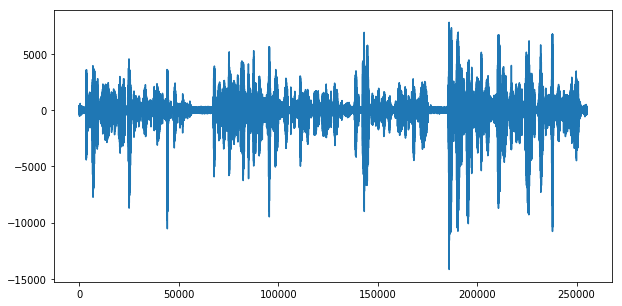

In [93]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(len(data))],data)
# plt.xlim(7700,8500)
plt.show()

Sampling rate : 16000
[-23 -19 -18 ..., -36   9  60]
11.255 0.0888494002665482
(-1.84000000004+1.98787824643e-14j) 313502.130004


/Users/kazuki/.pyenv/versions/3.6.1/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


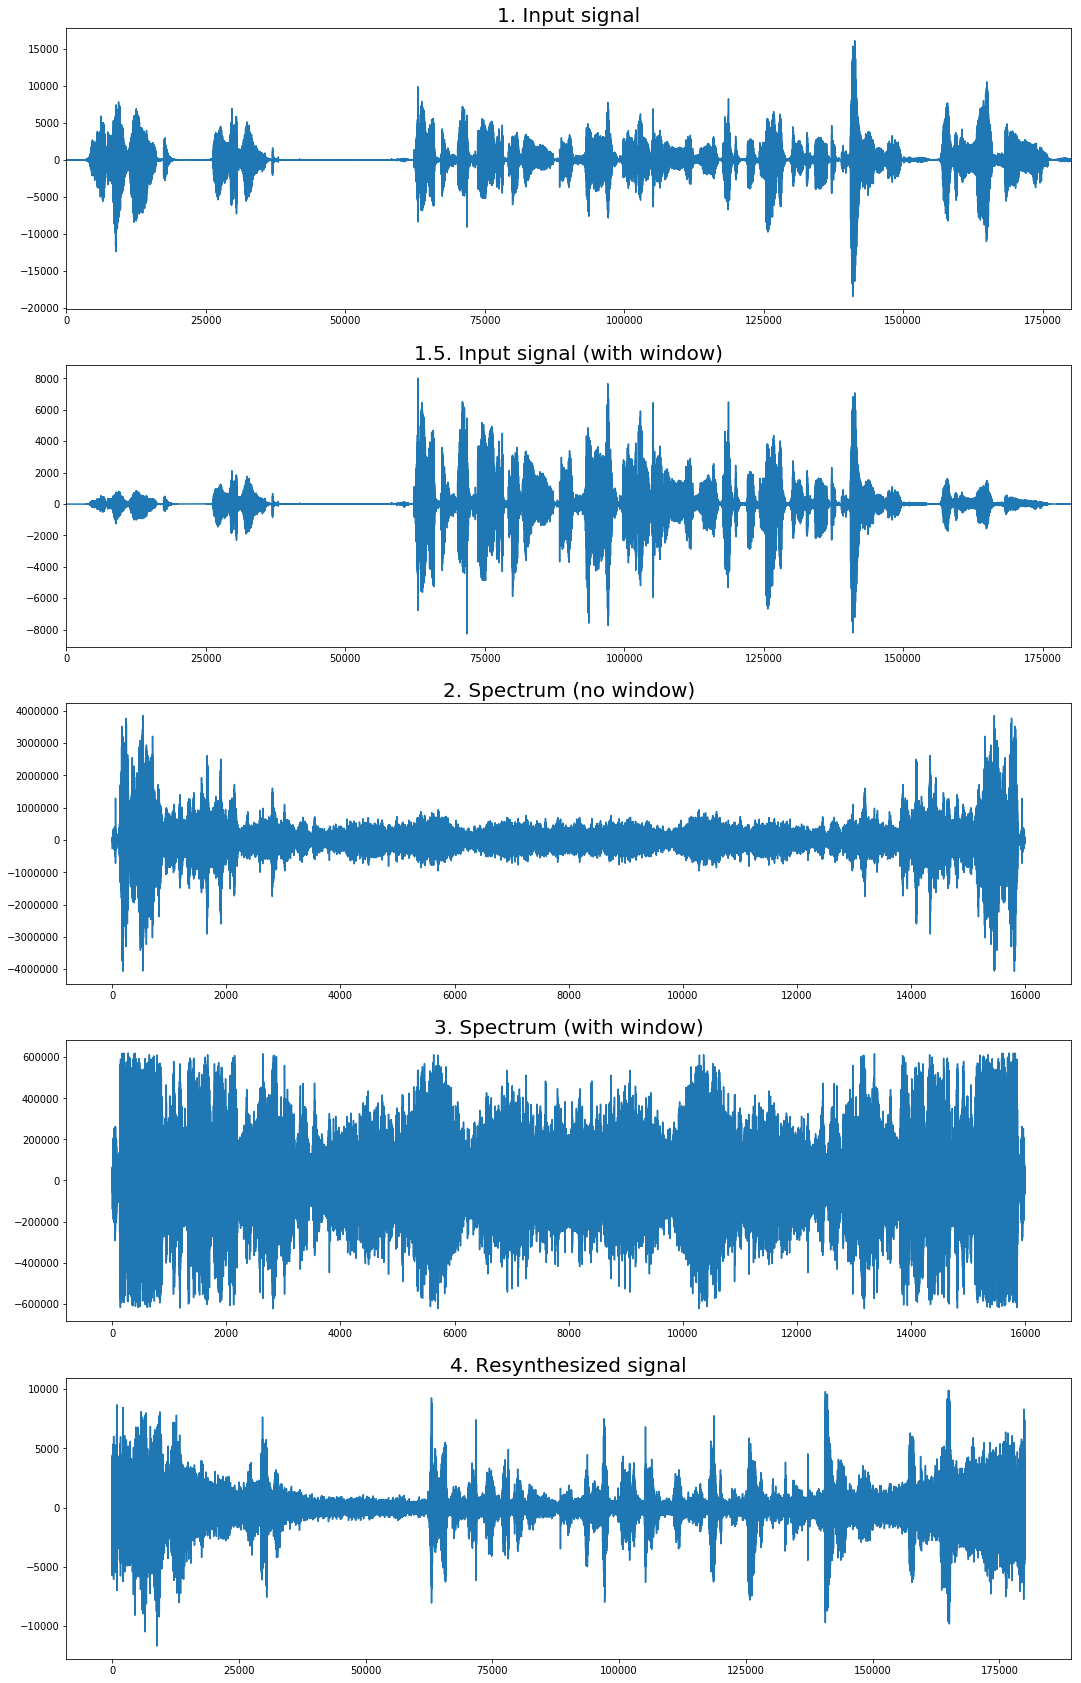

0.032 31.25


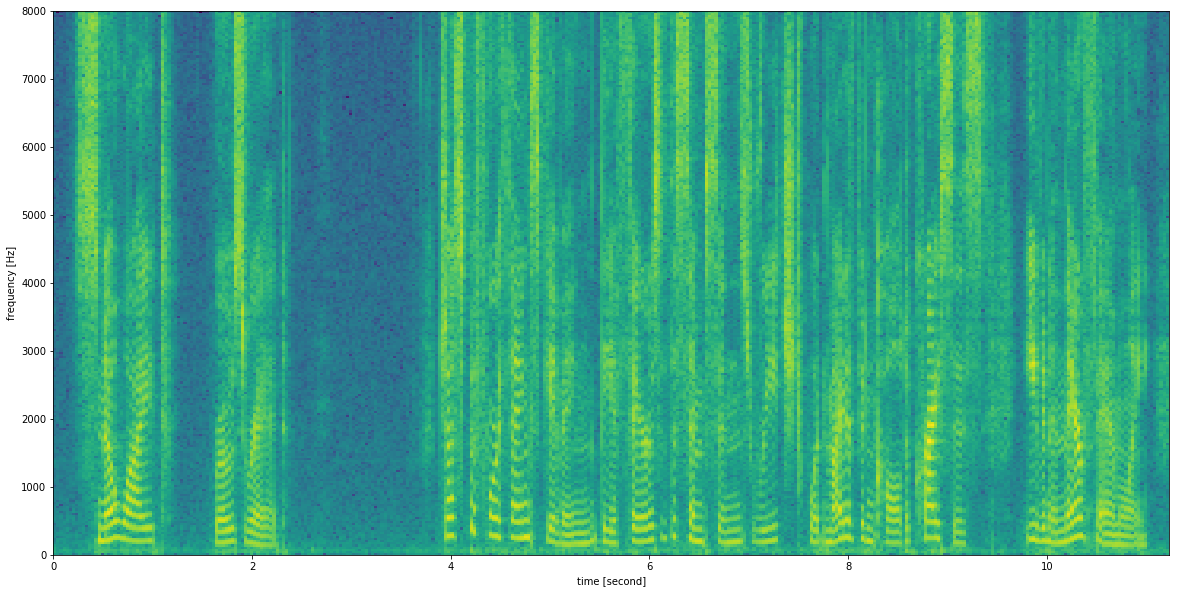

In [191]:
fs,data = load_wav("LibriSpeech/1553.wav")
freq,spec = fft_plot(data,fs)

In [129]:
# np.argmax(spec)
for i in np.argsort(spec)[:30]:
    print(freq[i],'Hz\t', spec[i],i)

43934.9188617 Hz	 (-3757958.18205+13421.747402j) 254165
42917.4658984 Hz	 (-2413777.1151-1729301.46274j) 248279
1182.5341016 Hz	 (-2413777.1151+1729301.46274j) 6841
42915.9101599 Hz	 (-2394161.19747-715939.256154j) 248270
1184.08984008 Hz	 (-2394161.19747+715939.256154j) 6850
42875.2880997 Hz	 (-2025602.47468-108240.528733j) 248035
1224.71190028 Hz	 (-2025602.47468+108240.528733j) 7085
1168.18673565 Hz	 (-1913461.78921-4817.51179654j) 6758
42931.8132643 Hz	 (-1913461.78921+4817.51179654j) 248362
42921.6145343 Hz	 (-1871384.33615-79443.7504497j) 248303
1178.38546566 Hz	 (-1871384.33615+79443.7504497j) 6817
42931.4675447 Hz	 (-1869503.85041-185245.139031j) 248360
1168.53245532 Hz	 (-1869503.85041+185245.139031j) 6760
1413.47483537 Hz	 (-1859846.07874-381046.717822j) 8177
42686.5251646 Hz	 (-1859846.07874+381046.717822j) 246943
42366.2158984 Hz	 (-1819739.88071-833060.83141j) 245090
1733.7841016 Hz	 (-1819739.88071+833060.83141j) 10030
42905.7114299 Hz	 (-1783719.16243-2211389.19125j) 248

## MFCC
- プリエンファシスフィルタで波形の高域成分を強調する
- 窓関数をかけた後にFFT（高速フーリエ変換）して振幅スペクトルを求める
- 振幅スペクトルにメルフィルタバンクをかけて圧縮する
- 上記の圧縮した数値列を信号とみなして離散コサイン変換する
- 得られたケプストラムの低次成分がMFCC

In [167]:
import wave
import numpy as np
import scipy.signal
import scipy.fftpack
import scipy.fftpack.realtransforms

def wavread(filename):
    wf = wave.open(filename, "r")
    fs = wf.getframerate()
    x = wf.readframes(wf.getnframes())
    x = np.frombuffer(x, dtype="int16") / 32768.0  # (-1, 1)に正規化
    wf.close()
    return x, float(fs)

def hz2mel(f):
    """Hzをmelに変換"""
    return 1127.01048 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
    """melをhzに変換"""
    return 700.0 * (np.exp(m / 1127.01048) - 1.0)

def melFilterBank(fs, nfft, numChannels):
    """メルフィルタバンクを作成"""
    # ナイキスト周波数（Hz）
    fmax = fs / 2
    # ナイキスト周波数（mel）
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大数
    nmax = nfft / 2
    # 周波数解像度（周波数インデックス1あたりのHz幅）
    df = fs / nfft
    # メル尺度における各フィルタの中心周波数を求める
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    # 各フィルタの中心周波数をHzに変換
    fcenters = mel2hz(melcenters)
    # 各フィルタの中心周波数を周波数インデックスに変換
    indexcenter = np.round(fcenters / df)
    # 各フィルタの開始位置のインデックス
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))

    filterbank = np.zeros((numChannels, int(nmax)))
    for c in np.arange(0, numChannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            i=int(i)
            filterbank[c, i] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            i=int(i)
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return scipy.signal.lfilter([1.0, -p], 1, signal)

def mfcc(signal, nfft, fs, nceps):
    """信号のMFCCパラメータを求める
    signal: 音声信号
    nfft  : FFTのサンプル数
    nceps : MFCCの次元"""
    # プリエンファシスフィルタをかける
    p = 0.97         # プリエンファシス係数
    signal = preEmphasis(signal, p)

    # ハミング窓をかける
    hammingWindow = np.hamming(len(signal))
    signal = signal * hammingWindow

    # 振幅スペクトルを求める
    spec = np.abs(np.fft.fft(signal, nfft))[:int(nfft/2)]
    fscale = np.fft.fftfreq(nfft, d = 1.0 / fs)[:int(nfft/2)]

    # メルフィルタバンクを作成
    numChannels = 20  # メルフィルタバンクのチャネル数
    df = fs / nfft   # 周波数解像度（周波数インデックス1あたりのHz幅）
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)


    # 定義通りに書いた場合
    # 振幅スペクトルに対してフィルタバンクの各フィルタをかけ、振幅の和の対数をとる
    mspec = np.log10(np.dot(spec, filterbank.T))


    # 離散コサイン変換
    ceps = scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)

    # 低次成分からnceps個の係数を返す
    return ceps[:nceps]

#wavファイルと次元数を入れてMFCCを抽出
#   nfft:FFTのサンプル数　1024, 2048, 4096
#   nceps:MFCCの次元数　大体12次元が多い
#   ※ fs * cuttime >= nfft/2 を満たす値を与えなければいけない
def get_feature(wavfile,nfft,nceps):
    # 音声をロード
    wav, fs = wavread(wavfile)
    t = np.arange(0.0, len(wav) / fs, 1/fs)
    
    # 音声波形の中心部分を切り出す
    center = len(wav) / 2  # 中心のサンプル番号
    cuttime = 0.8         # 切り出す長さ [s]
    wavdata = wav[int(center - cuttime/2*fs) : int(center + cuttime/2*fs)]
    
    ceps = mfcc(wavdata, nfft, fs, nceps)
    return ceps.tolist()

In [168]:
mfcc(data, len(data),44100, 12)

array([  3.78734655e+01,  -3.20764476e+00,  -1.27288869e+00,
        -9.51127835e-01,  -7.65184677e-01,  -4.49987513e-01,
         1.24432056e-02,  -5.71310028e-03,  -1.43912487e-01,
        -2.49491078e-03,   1.28337030e-01,   1.06601357e-01])

In [ ]:
def noise_filter(data,fs):
    
    L = len(data) # Signal length（サンプル数）

    data_length = L /fs
    delta_freq = 1/data_length
#     print(data_length,delta_freq)

    # 窓関数
    win = hamming(L)

    # フーリエ変換
    spectrum_nw = fft(data) # 窓関数なし
    spectrum = fft(data * win) # 窓関数あり
    
    # 2シグマ以上を低減
    np.std
    
    spectrum[955:960] = 0.
    spectrum[-970:-935] = 0.
    
    half_spectrum_nw = abs(spectrum_nw[:int( L / 2) + 1])
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    
    # フーリエ逆変換
    resyn_sig = ifft(spectrum)
    resyn_sig /= win


## 103(f), 1116(f), 1334(m), 1553(f)

In [171]:
fs1,data1 = load_wav("LibriSpeech/103.wav")
fs2,data2 = load_wav("LibriSpeech/1116.wav")
fs3,data3 = load_wav("LibriSpeech/1334.wav")
fs4,data4 = load_wav("LibriSpeech/1553.wav")

Sampling rate : 16000
[-213 -181 -203 ...,  108   15 -310]
Sampling rate : 16000
[  0   7   5 ..., -12   1   3]
Sampling rate : 16000
[59 75 78 ..., 31 53 43]
Sampling rate : 16000
[-23 -19 -18 ..., -36   9  60]


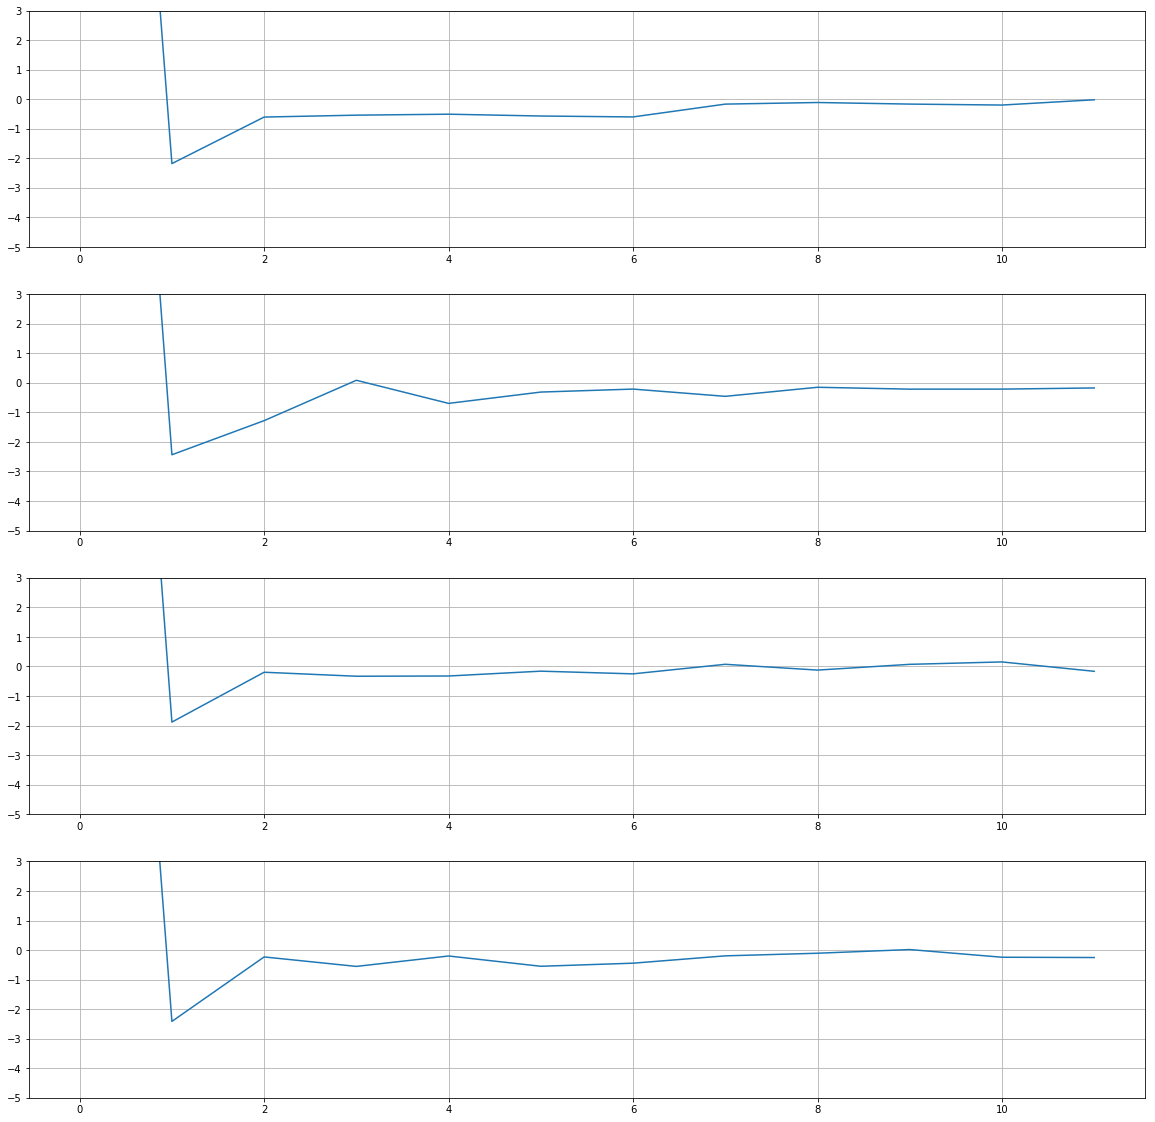

In [192]:
fig = plt.figure(figsize=(20,20))
i=1
for fs,data in [(fs1,data1),(fs2,data2),(fs3,data3),(fs4,data4)]:
    
#     data = noise_filter(data)
    fig.add_subplot(4,1,i)
    melbank = mfcc(data, len(data),fs, 12)
    plt.plot(melbank)
    plt.ylim(-5,3)
    plt.grid()
    i+=1
    
plt.show()

### $\Delta t  \Delta f = 1$
### $\Delta f  = \frac{f_s}{N}$で，周波数領域のデータ点がサンプル数/2，サンプル間で$\frac{1}{f_s}$秒->データの時間長は$\frac{N}{f_s}$

In [ ]:
win = hamming(L)
fs = 44100

# スペクトログラムを描画
pxx, freqs, bins, im = specgram(data, NFFT=N, fs=wf.getframerate(), noverlap=0, window=hammingWindow)
axis([0, length, 0, wf.getframerate() / 2])
xlabel("time [second]")
ylabel("frequency [Hz]")

show()

In [190]:
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
import numpy as np


def fft_plot(data,fs):
    # fs = Sampling rate
    L = len(data) # Signal length（サンプル数）

    data_length = L /fs
    delta_freq = 1/data_length
    print(data_length,delta_freq)

    # 窓関数
    win = hamming(L)

    # フーリエ変換
    spectrum_nw = fft(data) # 窓関数なし
    spectrum = fft(data * win) # 窓関数あり
    
    # 165Hzをカット
#     spectrum[955:960] = 0.
#     spectrum[-970:-935] = 0.

    m = np.mean(spectrum)
    s = np.std(spectrum)
    print(m,s)
    
    spectrum = np.array([0. if abs(i-m) > 2*s else i for i in spectrum])
    
    half_spectrum_nw = abs(spectrum_nw[:int( L / 2) + 1])
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    
    # フーリエ逆変換
    resyn_sig = ifft(spectrum)
    resyn_sig /= win

    # 図を表示
    fig = plt.figure(figsize=(18,30))

    fig.add_subplot(511)
    plt.plot(data)
    plt.xlim([0, L])
    plt.title("1. Input signal", fontsize = 20)

    fig.add_subplot(512)
    plt.plot(data * win)
    plt.xlim([0, L])
    plt.title("1.5. Input signal (with window)", fontsize = 20)

    fig.add_subplot(513)
    plt.plot(np.arange(len(spectrum_nw))*delta_freq, spectrum_nw)
#     plt.xlim([0, len(spectrum_nw)/2])
    plt.title("2. Spectrum (no window)", fontsize = 20)

    fig.add_subplot(514)
    plt.plot(np.arange(len(spectrum))*delta_freq, spectrum)
#     plt.xlim([0, len(spectrum)/2])
    plt.title("3. Spectrum (with window)", fontsize = 20)

    fig.add_subplot(515)
    plt.plot(resyn_sig)
#     plt.xlim([0, 200])
    plt.title("4. Resynthesized signal", fontsize = 20)

    plt.show()

    l = 512
    data_length = l/fs
    delta_freq = 1/data_length
    print(data_length,delta_freq)
    
    plt.figure(figsize=(20,10))
    # スペクトログラムを描画
    pxx, freqs, bins, im = plt.specgram(data, NFFT=l, Fs=fs, noverlap=0, window=hamming(l))
#     plt.yticks(np.arange(20000)[::100],np.arange(20000)[::100]*delta_freq)
#     plt.ylim(0,1000)
    plt.xlabel("time [second]")
    plt.ylabel("frequency [Hz]")

    plt.show()
    
#     return (np.arange(len(half_spectrum))*delta_freq, half_spectrum)
    return (np.arange(len(spectrum))*delta_freq, spectrum)



In [44]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

0.08533333333333333 11.71875


/Users/kazuki/.pyenv/versions/3.6.1/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


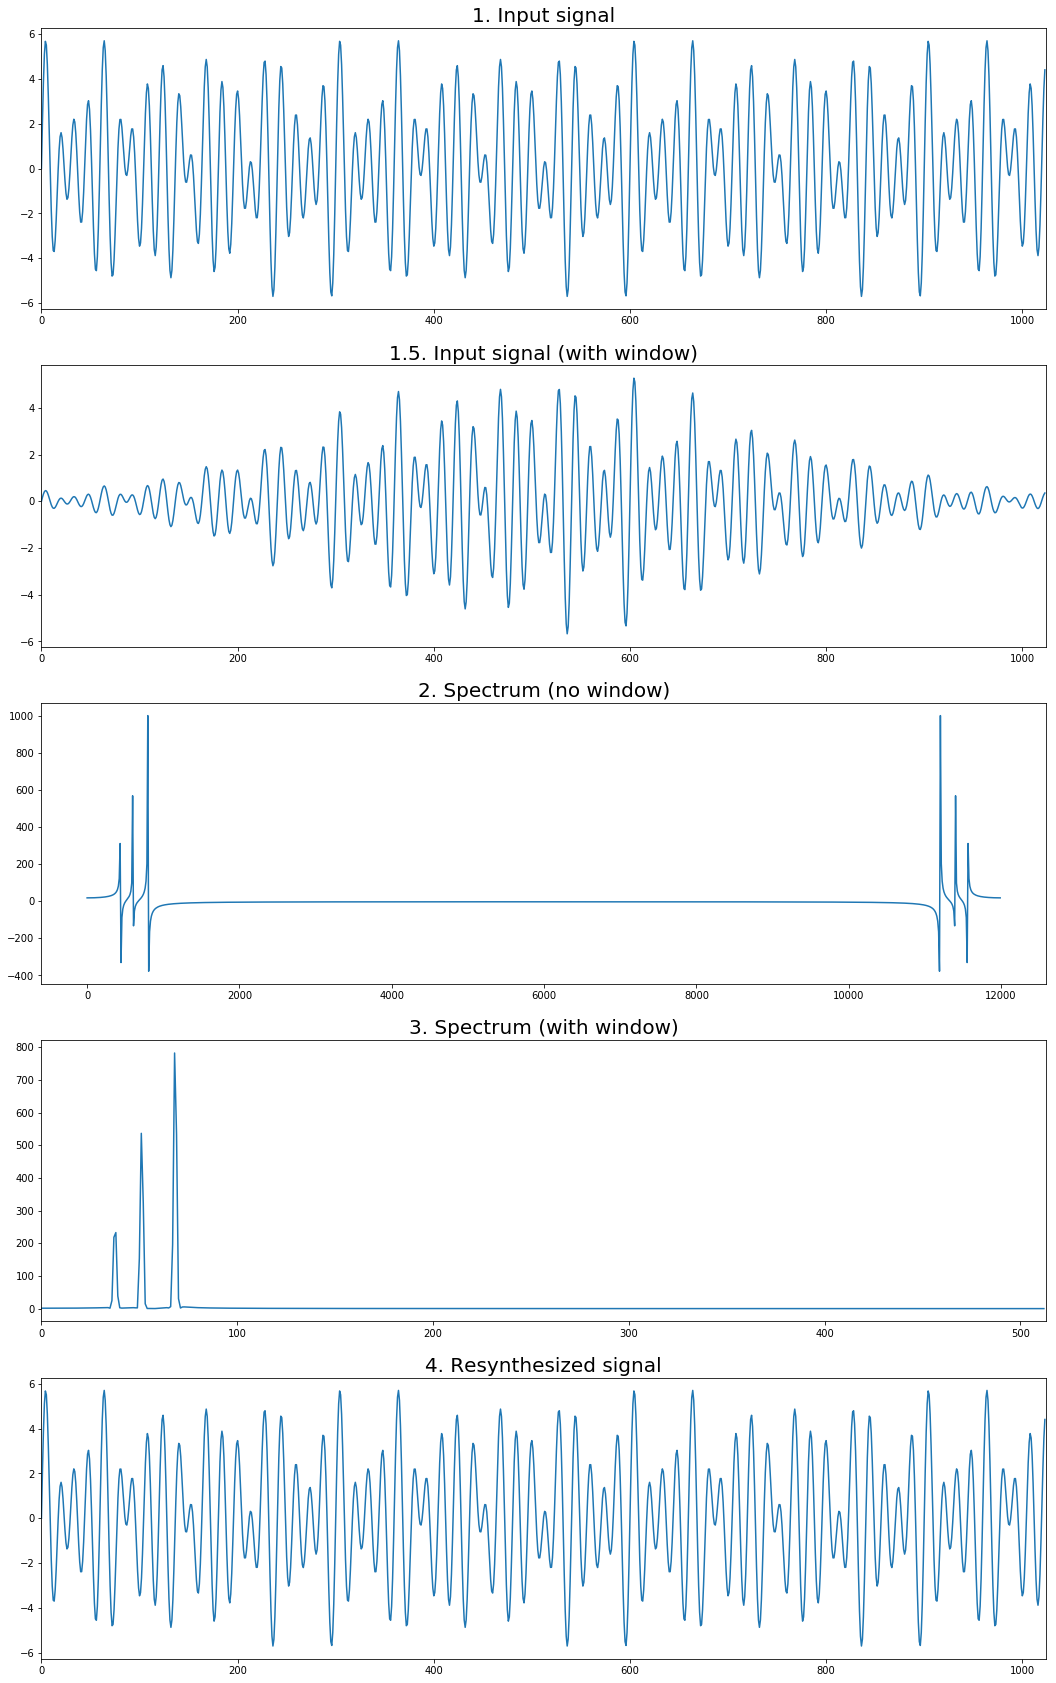

In [120]:
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
import numpy as np

fs = 12000 # Sampling rate
L = 1024 # Signal length（サンプル数）

data_length = 1024 /12000
delta_freq = 1/data_length
print(data_length,delta_freq)

# 440[Hz]のサイン波を作る。
sine_440 = sin(2. * pi * arange(L) * 440. / fs)
# 600[Hz]のサイン波を作る。
sine_600 = 2 * sin(2. * pi * arange(L) * 600. / fs)
# 800[Hz]のサイン波を作る。
sine_800 = 3 * sin(2. * pi * arange(L) * 800. / fs)

# 全部足す
sig = sine_440 + sine_600 + sine_800

# 窓関数
win = hamming(L)

# フーリエ変換
spectrum_nw = fft(sig) # 窓関数なし
spectrum = fft(sig * win) # 窓関数あり
half_spectrum_nw = abs(spectrum_nw[:int( L / 2) + 1])
half_spectrum = abs(spectrum[: int(L / 2) + 1])

# フーリエ逆変換
resyn_sig = ifft(spectrum)
resyn_sig /= win

# 図を表示
fig = plt.figure(figsize=(18,30))

fig.add_subplot(511)
plt.plot(sig)
plt.xlim([0, L])
plt.title("1. Input signal", fontsize = 20)

fig.add_subplot(512)
plt.plot(sig * win)
plt.xlim([0, L])
plt.title("1.5. Input signal (with window)", fontsize = 20)

fig.add_subplot(513)
plt.plot(np.arange(len(spectrum_nw))*delta_freq, spectrum_nw)
# plt.xlim([0, 1200])
# plt.xticks(np.arange(500)[::25],np.arange(500)[::25]*delta_freq,rotation=45)
plt.title("2. Spectrum (no window)", fontsize = 20)

fig.add_subplot(514)
plt.plot(half_spectrum)
plt.xlim([0, len(half_spectrum)])
plt.title("3. Spectrum (with window)", fontsize = 20)

fig.add_subplot(515)
plt.plot(resyn_sig)
plt.xlim([0, L])
plt.title("4. Resynthesized signal", fontsize = 20)

plt.show()

